In [424]:
## Importing required packages
import pandas as pd
import numpy as np
from pvlib import location, irradiance
import matplotlib.pyplot as plt
import sys
import math

In [425]:
## Define time range
tz='US/Pacific'
start = pd.Timestamp('2023-06-01 00:00:00', tz=tz)
end = pd.Timestamp('2023-06-03 00:00:00', tz=tz)
freq = '15min'
time_index = pd.date_range(start, end, freq=freq)

## Calculate the time difference (dt) between consecutive timestamps in minutes
dt = (time_index[1] - time_index[0]).total_seconds() / 60  
time = np.array(time_index)
num_steps = len(time)

In [426]:
## Solar intensities calculator (for different walls orientations and horizontal roof)

def get_solar_irradiance(latitude, longitude, tz, time_index):

    # Create location object
    site = location.Location(latitude, longitude, tz=tz)

    # Calculate solar position
    solar_position = site.get_solarposition(time_index)

    # Calculate clearsky irradiance
    clearsky = site.get_clearsky(time_index)
    
    
    # Create empty DataFrame to store results
    results = pd.DataFrame(index=time_index)

    # Calculate irradiance components for each wall orientation
    for surface_azimuth in [0, 90, 180, 270]:
        solar_irradiance = irradiance.get_total_irradiance(surface_tilt = 90,
                                                               surface_azimuth = surface_azimuth,
                                                               dni = clearsky['dni'],                       # DNI : Direct Normal Irradiation 
                                                               ghi = clearsky['ghi'],                       # GHI : Global Horizontal Irradiation
                                                               dhi = clearsky['dhi'],                       # DHI : Diffuse Horizontal Irradiation 
                                                               solar_zenith = solar_position['apparent_zenith'],
                                                               solar_azimuth = solar_position['azimuth'])
        
        solar_irradiance_horizontal = irradiance.get_total_irradiance(surface_tilt = 0,
                                                               surface_azimuth = 180,
                                                               dni = clearsky['dni'],                       # DNI : Direct Normal Irradiation 
                                                               ghi = clearsky['ghi'],                       # GHI : Global Horizontal Irradiation
                                                               dhi = clearsky['dhi'],                       # DHI : Diffuse Horizontal Irradiation 
                                                               solar_zenith = solar_position['apparent_zenith'],
                                                               solar_azimuth = solar_position['azimuth'])

        
        # Store the solar intensity in the DataFrame
        results.loc[time_index, surface_azimuth] = solar_irradiance['poa_direct']                  ## {poa_global : Total in-plane irradiance (W/m^2)/ poa_direct : Total in-plane beam irradiance (W/m^2)/ poa_diffuse : Total in-plane diffuse irradiance (W/m^2)/...
                                                                                                   ## ...poa_sky_diffuse : In-plane diffuse irradiance from sky (W/m^2)/ poa_ground_diffuse : In-plane diffuse irradiance from ground (W/m^2)}


    results.loc[time_index, ['Horizontal']] = solar_irradiance_horizontal ['poa_direct']
    return results

# Calculate solar irradiance
solar_irradiance = get_solar_irradiance(latitude=38.544907, longitude=-121.740517, tz='US/Pacific', time_index=time_index)

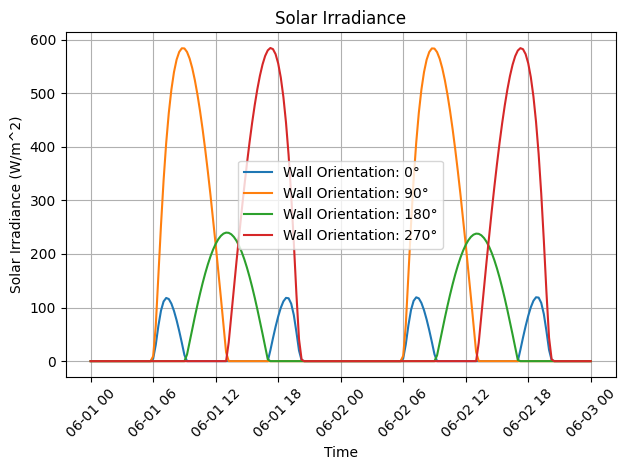

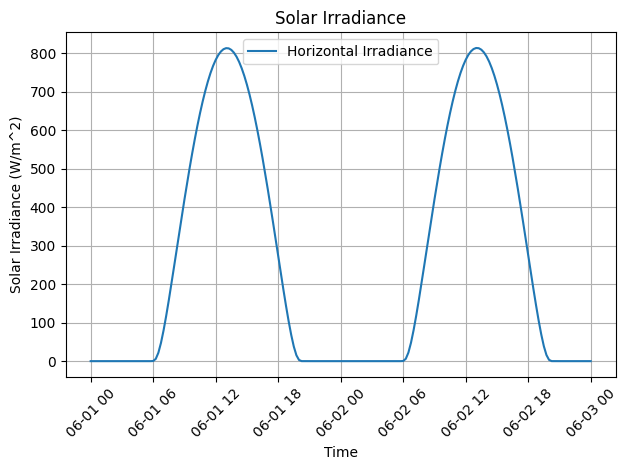

In [427]:
# Plotting solar intensities for different walls orientations
fig, ax = plt.subplots()

for surface_azimuth in [0, 90, 180, 270]:
    ax.plot(solar_irradiance.index, solar_irradiance[surface_azimuth], label=f'Wall Orientation: {surface_azimuth}°')

ax.set_xlabel('Time')
ax.set_ylabel('Solar Irradiance (W/m^2)')
ax.set_title('Solar Irradiance')
ax.legend()
ax.grid(True)
plt.xticks(rotation=45) 
plt.tight_layout()
plt.show()

# Plotting solar intensities for horizontal roof
fig, ax = plt.subplots()
ax.plot(solar_irradiance.index, solar_irradiance['Horizontal'], label='Horizontal Irradiance')
ax.set_xlabel('Time')
ax.set_ylabel('Solar Irradiance (W/m^2)')
ax.set_title('Solar Irradiance')
ax.legend()
ax.grid(True)
plt.xticks(rotation=45)  
plt.tight_layout()
plt.show()

In [428]:
# Load data from .CSV file (time-varying electricity price signal ($))
elec_price = pd.read_csv('Time_varying_elec_rates.csv')

# Convert the time column to datetime format
elec_price['Time'] = pd.to_datetime(elec_price['Time'])

# Set the timestamp column as the index
elec_price.set_index('Time', inplace=True)

# Define the expected time interval
expected_interval = pd.to_timedelta(freq) 

# Calculate the average time difference in the CSV file
CSV_file_time_interval = (elec_price.index[1:] - elec_price.index[:-1]).mean()

if CSV_file_time_interval > expected_interval:
    # Transitioning to Smaller Time Intervals through Upsampling
    new_interval = expected_interval
    elec_price = elec_price.resample(new_interval).interpolate(method='pad') 

else:
    # Transitioning to Larger Time Intervals through Downsampling
    new_interval = expected_interval
    elec_price = elec_price.resample(new_interval).mean()

In [429]:
# Load data from .CSV file (Ambient temperature)
amb_temp = pd.read_csv('Amb_temp_and_hot_water_draw_mass_flow_rate.csv')

# Convert the time column to datetime format
amb_temp['Time'] = pd.to_datetime(amb_temp['Time'])

# Set the timestamp column as the index
amb_temp.set_index('Time', inplace=True)

# Calculate the average time difference in the CSV file
CSV_file_time_interval = (amb_temp.index[1:] - amb_temp.index[:-1]).mean()

if CSV_file_time_interval > expected_interval:
    # Transitioning to Smaller Time Intervals through Upsampling
    new_interval = expected_interval
    amb_temp = amb_temp.resample(new_interval).interpolate(method='pad')
    
else:
    # Transitioning to Larger Time Intervals through Downsampling
    new_interval = expected_interval
    amb_temp = amb_temp.resample(new_interval).mean()


In [430]:
# Load data from .CSV file (Hot water drawn)
hot_water_drawn = pd.read_csv('Amb_temp_and_hot_water_draw_mass_flow_rate.csv')

# Convert the time column to datetime format
hot_water_drawn['Time'] = pd.to_datetime(hot_water_drawn['Time'])

# Set the timestamp column as the index
hot_water_drawn.set_index('Time', inplace=True)

# Calculate the average time difference in the CSV file
CSV_file_time_interval = (hot_water_drawn.index[1:] - hot_water_drawn.index[:-1]).mean()

if CSV_file_time_interval > expected_interval:
    # Transitioning to Smaller Time Intervals through Upsampling
    new_interval = expected_interval
    hot_water_drawn = hot_water_drawn.resample(new_interval).interpolate(method='pad')

else:
    # Transitioning to Larger Time Intervals through Downsampling
    new_interval = expected_interval
    hot_water_drawn = hot_water_drawn.resample(new_interval).mean()

In [431]:
#### Input parameters for building

c_p_air = 1000       # Air specific heat capacity [J/kg.k]
c_p_wall = 780      # Walls specific heat capacity [J/kg.k]
c_p_floor = 880 

rho_air = 1.2     # Air density [kg/m3]
rho_wall = 1920      # Brick density [kg/m3]
rho_floor = 2500

k_wall = 0.72    # Thermal conductivity of walls (W/m.k) - Brick conductivity
k_wind = 1       # Thermal conductivity of windows (W/m.k) - Glass conductivity
h_conv_ex = 25      # Convection heat transfer coefficient on the exterior wall (W/m2.k)
h_conv_in = 8       # Convection heat transfer coefficient on the exterior wall (W/m2.k)


h_ceil = 2.7            # The height of the building (m)
a_floor = 185          # The area of the building (m2) (assuming a square space)
a_roof = a_floor


w_wall = 0.1     # wall's thickness [m]
w_floor = 0.1
w_wind = 3.2*(0.001)     # thickness of the window [m]

alpha_wall = 0.7      # Absorptance coefficient of the walls (Red clay brick)
alpha_roof = 0.2
SHGC = 0.6       # solar heat gain coefficient of the windows

## Windows Areas [m2] 
a_wind_n = 0
a_wind_s = 0
a_wind_w = 0
a_wind_e = 3*2

## Walls Areas [m2] 
a_wall_n = (np.sqrt(a_floor) * h_ceil) - a_wind_n
a_wall_s = (np.sqrt(a_floor) * h_ceil) - a_wind_s
a_wall_w = (np.sqrt(a_floor) * h_ceil) - a_wind_w
a_wall_e = (np.sqrt(a_floor) * h_ceil) - a_wind_e

### Calculating heat capacitances
c_in_air = 666000.0
c_wall = rho_wall*c_p_wall*w_wall*(a_wall_n + a_wall_s + a_wall_w + a_wall_e)    # The heat capacity of walls [J/k]

c_wall_ex =  11772457.34   ## [J/k]
c_wall_in = 11772457.34    ## [J/k]


c_itm = 16280000.0

c_tot = c_in_air + c_wall_ex + c_wall_in + c_itm

###  Thermal resistances [k/W]
r_wall_ex = 0.0005088487328366421
r_wall = 0.004
r_wall_in = 0.0007950761450572532
r_wind =  0.0023
r_i = 0.00033783783783783786

r_tot = r_wall_in + r_wall + r_wall_ex

## Maximum heating capacities
Q_dot_FCU_AC = -11.62 * 1000   # Watt
P_elec_AC = 4.18    # KW


Q_dot_cond_WH = 10.76 * 1000   # Watt
P_elec_WH = 4.41     # KW

Q_dot_FCU_sim = -5.61 * 1000   # Watt
Q_dot_cond_sim = 9.66 * 1000    # Watt
P_elec_sim = 4.56     # KW

f = 0.3          # The fraction of 𝑃𝑡ℎ,𝑠𝑜𝑙𝑎𝑟 that is transmitted to the indoor air


In [432]:
# Window and wall areas (m2)
total_areas = np.sqrt(a_floor) * h_ceil

frac_windows = 0.1

## Windows Areas [m2] 
a_wind_n = frac_windows * total_areas
a_wind_s = frac_windows * total_areas
a_wind_w = frac_windows * total_areas
a_wind_e = frac_windows * total_areas

## Walls Areas [m2] 
a_wall_n = (1 - frac_windows) * total_areas
a_wall_s = (1 - frac_windows) * total_areas
a_wall_w = (1 - frac_windows) * total_areas
a_wall_e = (1 - frac_windows) * total_areas

In [433]:
### Input parameters for the water storage tank (3 nodes model)

r_t_wall = 1.029627934 ### k/W   thermal resistance of tank's wall
r_wl = 3*3.417569* (10**(-7))   # (k/W)    thermal resistance of water loop
k_water = 0.598 ### W/(m.k)       thermal conductivity of water 
tank_diam = 45.72 * (0.01)  ## m
A_cross_section_tank = math.pi * (0.25) * ((tank_diam)**2)
h = 152.4 * (0.01) ## m (height of tank)
r_t_cond = k_water * A_cross_section_tank / (h/3)    # thermal resistance of water due to thermal conductivity between two adjucent nodes in the tank
m_wl = 1.6 ### kg
c_p_w = 4200 ## J/kg.k'
m_fluid_tank = 210  # kg (water is used as a intermediate fluid in tank)
c_p_fluid = m_fluid_tank * c_p_w


In [434]:
## Calculating building's solar heat gain (4-nodes)
p_th_solar_wall = [0]*num_steps
p_th_solar_i = [0]*num_steps
p_th_solar_itm = [0]*num_steps
p_th_solar_total = [0]*num_steps
p_th_internal = [0]*num_steps

p_th_solar_wall_kW = [0]*num_steps
p_th_solar_i_kW = [0]*num_steps
p_th_solar_itm_kW = [0]*num_steps

for i in range(num_steps):
    ## Total amount of solar heat gain through walls and roof
    p_th_solar_wall [i] =  alpha_wall * (a_wall_n * solar_irradiance[0][i] + 
                                    a_wall_e * solar_irradiance[90][i] + 
                                    a_wall_s * solar_irradiance[180][i]
                                    + a_wall_w * solar_irradiance[270][i]) + alpha_roof *(a_floor * solar_irradiance['Horizontal'][i]) # W                      
    
    p_th_solar_i [i] = f * SHGC * (a_wind_n * solar_irradiance[0][i] 
                                   + a_wind_e * solar_irradiance[90][i] + 
                                   a_wind_s * solar_irradiance[180][i]
                                   + a_wind_w * solar_irradiance[270][i])    # W
    p_th_solar_itm [i] = (1-f) * SHGC * (a_wind_n * solar_irradiance[0][i] 
                                         + a_wind_e * solar_irradiance[90][i] + 
                                         a_wind_s * solar_irradiance[180][i] + 
                                         a_wind_w * solar_irradiance[270][i])    # W
    
    p_th_solar_total [i] = p_th_solar_wall [i] + p_th_solar_i [i] + p_th_solar_itm [i]  # Total solar heat gain [W]
    

p_th_solar_wall_kW = [0.001 * val for val in p_th_solar_wall]
p_th_solar_i_kW = [0.001 * val for val in p_th_solar_i]
p_th_solar_itm_kW = [0.001 * val for val in p_th_solar_itm]
    

In [435]:
# defining known variables (like ambient temperature, electricity price, ...)
T_amb = [0]*num_steps
m_dot_w = [0]*num_steps
T_c = [0]*num_steps
cost_elec = [0]*(num_steps)
for i in range(num_steps):
    T_amb [i] = amb_temp.loc[amb_temp.index[i],'T_Outdoor_Temperature_C'] #deg C
    m_dot_w [i] = hot_water_drawn.loc[hot_water_drawn.index[i],'m_dot_water']  # kg/s
    cost_elec [i] = elec_price.loc[elec_price.index[i],'price']
    T_c [i] = 15

In [436]:
# Set comfort ranges for T_in and T_w
comfort_range_T_in = (24, 26)  # Comfortable range for indoor air temperature 
comfort_range_T_w = (45, 60)  # Comfortable range for water storage tank temperature 

In [437]:
## Developing state space matrixes for the 4 nodes building model and 3 nodes model for the water storage tank (using exact method to discretize them)
## X_dot = A_c * X + B_c * U + E_c * D             #(D: disturbance vector)

## X = [T_in, T_itm, T_wall_in, T_wall_ex, T_tank_bottom, T_tank_mid, T_tank_up, T_w_bottom, T_w_mid, T_w_up]
## U = [U_AC, U_WH, U_SIM]
## D = [T_amb, p_th_solar_i, p_th_solar_itm, p_th_solar_wall, p_th_internal, T_C (feed cold water temperature)]
A_c = np.zeros((10, 10, num_steps))
B_c = np.zeros((10, 3, num_steps))
E_c = np.zeros((10, 6, num_steps))

X = np.zeros((10, num_steps))
U = np.zeros((3, num_steps))
D = np.zeros((6, num_steps))



for i in range (num_steps):
    # Define the matrix A (continuous form) --time varying
    A_c[0,0,i] = -(1/c_in_air)*((1/r_wall_in)+(1/r_wind)+(1/r_i))
    A_c[0,1,i] = 1/(c_in_air*r_i)
    A_c[0,2,i] = 1/(c_in_air*r_wall_in)
    A_c[0,3,i] = 0
    A_c[0,4,i] = 0
    A_c[0,5,i] = 0
    A_c[0,6,i] = 0
    A_c[0,7,i] = 0
    A_c[0,8,i] = 0
    A_c[0,9,i] = 0
    
    
        
    A_c[1,0,i] = 1/(c_itm*r_i)
    A_c[1,1,i] = -1/(c_itm*r_i)
    A_c[1,2,i] = 0
    A_c[1,3,i] = 0
    A_c[1,4,i] = 0
    A_c[1,5,i] = 0
    A_c[1,6,i] = 0
    A_c[1,7,i] = 0
    A_c[1,8,i] = 0
    A_c[1,9,i] = 0
    
    
    A_c[2,0,i] = 1/(c_wall_in*r_wall_in)
    A_c[2,1,i] = 0
    A_c[2,2,i] = -1/(c_wall_in*r_wall) -1/(c_wall_in*r_wall_in)
    A_c[2,3,i] = 1/(c_wall_in*r_wall)
    A_c[2,4,i] = 0
    A_c[2,5,i] = 0
    A_c[2,6,i] = 0
    A_c[2,7,i] = 0
    A_c[2,8,i] = 0
    A_c[2,9,i] = 0
    
    
    A_c[3,0,i] = 0 
    A_c[3,1,i] = 0
    A_c[3,2,i] = 1/(c_wall_ex*r_wall)
    A_c[3,3,i] = -(1/(c_wall_ex*r_wall_ex))-(1/(c_wall_ex*r_wall))
    A_c[3,4,i] = 0
    A_c[3,5,i] = 0
    A_c[3,6,i] = 0
    A_c[3,7,i] = 0
    A_c[3,8,i] = 0
    A_c[3,9,i] = 0
    
    
    A_c[4,0,i] = 9/(c_p_fluid*r_t_wall)
    A_c[4,1,i] = 0
    A_c[4,2,i] = 0
    A_c[4,3,i] = 0
    A_c[4,4,i] = (-3/(r_t_cond*c_p_fluid)) + (-9/(r_t_wall*c_p_fluid)) + (-9/(r_wl*c_p_fluid))
    A_c[4,5,i] = (3/(r_t_cond*c_p_fluid))
    A_c[4,6,i] = 0
    A_c[4,7,i] = 9/(r_wl*c_p_fluid)
    A_c[4,8,i] = 0
    A_c[4,9,i] = 0
    
    
    
    A_c[5,0,i] = 9/(r_t_wall*c_p_fluid)
    A_c[5,1,i] = 0
    A_c[5,2,i] = 0
    A_c[5,3,i] = 0
    A_c[5,4,i] = 3/ (c_p_fluid*r_t_cond)
    A_c[5,5,i] = (-6/(c_p_fluid*r_t_cond)) + (-9/(r_t_wall*c_p_fluid)) + (-9/(c_p_fluid*r_wl))
    A_c[5,6,i] = (3/(r_t_cond*c_p_fluid))
    A_c[5,7,i] = 0
    A_c[5,8,i] = 9/((c_p_fluid*r_wl))
    A_c[5,9,i] = 0
    
    
    
    A_c[6,0,i] = 9/(c_p_fluid * r_t_wall)
    A_c[6,1,i] = 0
    A_c[6,2,i] = 0
    A_c[6,3,i] = 0
    A_c[6,4,i] = 0
    A_c[6,5,i] = 3/(r_t_cond*c_p_fluid)
    A_c[6,6,i] = (-9/(r_t_wall*c_p_fluid)) + (-9/(r_wl*c_p_fluid)) + (-3/(c_p_fluid*r_t_cond))
    A_c[6,7,i] = 0
    A_c[6,8,i] = 0
    A_c[6,9,i] = 9/(c_p_fluid * r_wl)
    
    
    A_c[7,0,i] = 0
    A_c[7,1,i] = 0
    A_c[7,2,i] = 0
    A_c[7,3,i] = 0
    A_c[7,4,i] = 9/(m_wl*c_p_w*r_wl)
    A_c[7,5,i] = 0
    A_c[7,6,i] = 0
    A_c[7,7,i] = (-9/(m_wl*c_p_w*r_wl)) + (-3*m_dot_w [i]/m_wl)
    A_c[7,8,i] = 0
    A_c[7,9,i] = 0
    
    
    A_c[8,0,i] = 0
    A_c[8,1,i] = 0
    A_c[8,2,i] = 0
    A_c[8,3,i] = 0
    A_c[8,4,i] = 0
    A_c[8,5,i] = 9/(m_wl*c_p_w*r_wl)
    A_c[8,6,i] = 0
    A_c[8,7,i] = 3*m_dot_w [i]/m_wl
    A_c[8,8,i] = (-9/(m_wl*c_p_w*r_wl)) + (-3*m_dot_w [i]/m_wl)
    A_c[8,9,i] = 0
    
    
    
    A_c[9,0,i] = 0
    A_c[9,1,i] = 0
    A_c[9,2,i] = 0
    A_c[9,3,i] = 0
    A_c[9,4,i] = 0
    A_c[9,5,i] = 0
    A_c[9,6,i] = 9/(r_wl*m_wl*c_p_w)
    A_c[9,7,i] = 0
    A_c[9,8,i] = 3*m_dot_w [i]/m_wl
    A_c[9,9,i] = (-9/(m_wl*c_p_w*r_wl)) + (-3*m_dot_w [i]/m_wl)
    
    # Define the matrix B (continuous form)
    B_c[0,0,i] = Q_dot_FCU_AC/c_in_air
    B_c[0,1,i] = 0
    B_c[0,2,i] = Q_dot_FCU_sim/c_in_air
    
    B_c[1,0,i] = 0
    B_c[1,1,i] = 0
    B_c[1,2,i] = 0
    
    
    B_c[2,0,i] = 0
    B_c[2,1,i] = 0
    B_c[2,2,i] = 0
    
    
    B_c[3,0,i] = 0
    B_c[3,1,i] = 0
    B_c[3,2,i] = 0
    
    
    B_c[4,0,i] = 0
    B_c[4,1,i] = Q_dot_cond_WH/c_p_fluid
    B_c[4,2,i] = Q_dot_cond_sim/c_p_fluid
    
    B_c[5,0,i] = 0
    B_c[5,1,i] = Q_dot_cond_WH/c_p_fluid
    B_c[5,2,i] = Q_dot_cond_sim/c_p_fluid
    
    
    B_c[6,0,i] = 0
    B_c[6,1,i] = Q_dot_cond_WH/c_p_fluid
    B_c[6,2,i] = Q_dot_cond_sim/c_p_fluid
    
    
    B_c[7,0,i] = 0
    B_c[7,1,i] = 0
    B_c[7,2,i] = 0
    
    B_c[8,0,i] = 0
    B_c[8,1,i] = 0
    B_c[8,2,i] = 0
    
    B_c[9,0,i] = 0
    B_c[9,1,i] = 0
    B_c[9,2,i] = 0
    
    
    
    # Define the matrix C (continuous form)
    E_c[0,0,i] = 1/(r_wind*c_in_air)
    E_c[0,1,i] = 1/(c_in_air)
    E_c[0,2,i] = 0
    E_c[0,3,i] = 0
    E_c[0,4,i] = 1/(c_in_air)
    E_c[0,5,i] = 0
    
    
    E_c[1,0,i] = 0
    E_c[1,1,i] = 0
    E_c[1,2,i] = 1/(c_itm)
    E_c[1,3,i] = 0
    E_c[1,4,i] = 0
    E_c[1,5,i] = 0
    
    
    E_c[2,0,i] = 0
    E_c[2,1,i] = 0
    E_c[2,2,i] = 0
    E_c[2,3,i] = 0
    E_c[2,4,i] = 0
    E_c[2,5,i] = 0
    
    
    E_c[3,0,i] = 1/(c_wall_ex*r_wall_ex)
    E_c[3,1,i] = 0
    E_c[3,2,i] = 0
    E_c[3,3,i] = 1/(c_wall_ex)
    E_c[3,4,i] = 0
    E_c[3,5,i] = 0
    
    
    E_c[4,0,i] = 0
    E_c[4,1,i] = 0
    E_c[4,2,i] = 0
    E_c[4,3,i] = 0
    E_c[4,4,i] = 0
    E_c[4,5,i] = 0
    
    E_c[5,0,i] = 0
    E_c[5,1,i] = 0
    E_c[5,2,i] = 0
    E_c[5,3,i] = 0
    E_c[5,4,i] = 0
    E_c[5,5,i] = 0
    
    
    E_c[6,0,i] = 0
    E_c[6,1,i] = 0
    E_c[6,2,i] = 0
    E_c[6,3,i] = 0
    E_c[6,4,i] = 0
    E_c[6,5,i] = 0
    
    
    E_c[7,0,i] = 0
    E_c[7,1,i] = 0
    E_c[7,2,i] = 0
    E_c[7,3,i] = 0
    E_c[7,4,i] = 0
    E_c[7,5,i] = (3*m_dot_w [i])/m_wl 
    
    
    E_c[8,0,i] = 0
    E_c[8,1,i] = 0
    E_c[8,2,i] = 0
    E_c[8,3,i] = 0
    E_c[8,4,i] = 0
    E_c[8,5,i] = 0
    
    E_c[9,0,i] = 0
    E_c[9,1,i] = 0
    E_c[9,2,i] = 0
    E_c[9,3,i] = 0
    E_c[9,4,i] = 0
    E_c[9,5,i] = 0
    
    # Define the disturbances vector 
    D[0,i] = T_amb[i]  
    D[1,i] = p_th_solar_i[i] 
    D[2,i] = p_th_solar_itm[i] 
    D[3,i] = p_th_solar_wall[i] 
    D[4,i] = p_th_internal[i] 
    D[5,i] = T_c[i]

In [438]:
## Exact method discretization
import scipy.linalg


# A_c, B_c, E_c are the continuous-time matrices
Ts = dt*60  # Time step for discretization (in seconds)

A_d = np.zeros((10, 10, num_steps))
B_d = np.zeros((10, 3, num_steps))
E_d = np.zeros((10, 6, num_steps))
BcEc = np.zeros((10, 9, num_steps))
BdEd = np.zeros((10, 9, num_steps))
A_inv = np.zeros((10, 10, num_steps))

for i in range (num_steps):
    A_c [:,:,i] = np.array(A_c [:,:,i])
    B_c [:,:,i] = np.array(B_c [:,:,i])
    E_c [:,:,i] = np.array(E_c [:,:,i])
    
    BcEc [:,:,i] = np.hstack((B_c[:,:,i], E_c[:,:,i]))

    n_x, n_u = B_c[:,:,i].shape


    # Calculate the discrete-time A matrix using the matrix exponential method
    A_d [:,:,i] = scipy.linalg.expm(A_c [:,:,i] * Ts)
    A_inv [:,:,i] = np.linalg.inv(A_c [:,:,i])
    BdEd [:,:,i] = np.matmul(A_inv [:,:,i], np.matmul(A_d [:,:,i] - np.eye(A_c [:,:,i].shape[0]), BcEc [:,:,i]))
    B_d [:,:,i] = BdEd [:,:n_u,i]
    E_d [:,:,i] = BdEd [:,n_u:,i]

In [439]:
## Define time horizon for the open-loop and closed-loop MPC
tz='US/Pacific'
start_closed_loop = pd.Timestamp('2023-06-01 00:00:00', tz=tz)
end_closed_loop = pd.Timestamp('2023-06-01 21:00:00', tz=tz)
freq = freq
time_index_closed_loop = pd.date_range(start_closed_loop, end_closed_loop, freq=freq)

time_closed_loop = np.array(time_index_closed_loop)
num_steps_closed_loop = len(time_closed_loop)


In [440]:
print(A_d.shape)
print(X.shape)
print(U.shape)
print(D.shape)
print(B_d.shape)
print(E_d.shape)

(10, 10, 193)
(10, 193)
(3, 193)
(6, 193)
(10, 3, 193)
(10, 6, 193)


In [441]:
#### # Rule-based controller for temperature regulation

TSP_Th = 22 # deg C Temperature Set-point Thermostat 
Th_db = 0.55 # deg C about 1F deadband for thermostat
TSP_Aq = 49 # deg C Temperature Set-point Aquastat
Aq_db = 5.55  # deg C about 10 F deadband for Auqastat




In [442]:
import win32file

print(win32file._getmaxstdio())  # 512

win32file._setmaxstdio(1024*6)
print(win32file._getmaxstdio())  # 6144


6144
6144


In [443]:
## closed-Loop EMPC
from docplex.mp.model import Model
from docplex.mp.constants import WriteLevel
from docplex.mp.solution import SolveSolution
import numpy as np 



# Define the decision variables for state variables and control inputs
num_states = 10  # Number of states 
num_control_inputs = 3  # Number of control inputs (U_AC, U_WH, U_SIM)
num_disturbances = 6   # Number of disturbances (T_amb, P_th_solar_i, p_th_solar_itm, p_th_solar_wall, p_th_internal, T_c)


closed_loop_states = np.zeros ((num_states,num_steps_closed_loop + 1))
closed_loop_control_inputs = np.zeros ((num_control_inputs, num_steps_closed_loop))

warmstart_U_values = np.zeros ((num_control_inputs, num_steps_closed_loop))


#Initial condition for the first iteration
closed_loop_states[0,0] = 24
closed_loop_states[1,0] = 24
closed_loop_states[2,0] = 24
closed_loop_states[3,0] = T_amb[0]
closed_loop_states[4,0] = 45
closed_loop_states[5,0] = 50
closed_loop_states[6,0] = 55
closed_loop_states[7,0] = 45
closed_loop_states[8,0] = 50
closed_loop_states[9,0] = 55




# Penalty coefficients for temperature violations
penalty_T_in = 1  # Adjust this based on the importance of T_in violation
penalty_T_w = 1   # Adjust this based on the importance of T_w violation

    


#### Closed-loop MPC
for temp in range (num_steps_closed_loop):
    
    # Create the MILP model
    closed_loop_mpc = Model(name="closed_loop mpc")
    
   
    
    X = np.array([[closed_loop_mpc.continuous_var(name=f"X_{i}_{j}") for j in range(num_steps_closed_loop+1)] for i in range(num_states)])
    # U = np.array([[closed_loop_mpc.continuous_var(name=f"U_{i}_{j}",lb = 0, ub = 1) for j in range(num_steps_closed_loop)] for i in range(num_control_inputs)])
    U = np.array([[closed_loop_mpc.binary_var(name=f"U_{i}_{j}") for j in range(num_steps_closed_loop)] for i in range(num_control_inputs)])
    
    
    T_in_violation = [closed_loop_mpc.continuous_var(name=f"T_in_violation_{j}", lb=0) for j in range(num_steps_closed_loop + 1)]
    T_w_violation = [closed_loop_mpc.continuous_var(name=f"T_w_violation_{j}", lb=0) for j in range(num_steps_closed_loop + 1)]
    
    
    J = []   ### Objective function
    
    
    ### Initial condition
    closed_loop_mpc.add_constraint(X[0,0] == closed_loop_states[0,temp])
    closed_loop_mpc.add_constraint(X[1,0] == closed_loop_states[1,temp])
    closed_loop_mpc.add_constraint(X[2,0] == closed_loop_states[2,temp])
    closed_loop_mpc.add_constraint(X[3,0] == closed_loop_states[3,temp])
    closed_loop_mpc.add_constraint(X[4,0] == closed_loop_states[4,temp])
    closed_loop_mpc.add_constraint(X[5,0] == closed_loop_states[5,temp])
    closed_loop_mpc.add_constraint(X[6,0] == closed_loop_states[6,temp])
    closed_loop_mpc.add_constraint(X[7,0] == closed_loop_states[7,temp])
    closed_loop_mpc.add_constraint(X[8,0] == closed_loop_states[8,temp])
    closed_loop_mpc.add_constraint(X[9,0] == closed_loop_states[9,temp])
    
    
    
    
        
    #### Open-loop MPC
    # Add the state space equations as constraints
    M = 10
    for i in range(num_steps_closed_loop):
        A = A_d[:,:,i + temp]
        B = B_d[:,:,i + temp]
        E = E_d[:,:,i + temp]
        D = np.array([T_amb[i + temp], p_th_solar_i[i + temp], p_th_solar_itm[i + temp], p_th_solar_wall[i + temp], p_th_internal[i + temp], T_c[i + temp]])
        for m in range (num_states):
            # Create the docplex expressions for the state space equations
            state_eq = closed_loop_mpc.sum(A[m, j] * X[j, i] for j in range(num_states))
            control_eq = closed_loop_mpc.sum(B[m, k] * U[k, i] for k in range(num_control_inputs))
            disturbance_eq = closed_loop_mpc.sum(E[m, l] * D[l] for l in range(num_disturbances))
                
            # Add the constraint for the current time step
            closed_loop_mpc.add_constraint(X[m, i + 1] == state_eq + control_eq + disturbance_eq)
        # Add constraints for control inputs
        cont_inp_eq = closed_loop_mpc.sum (U[j, i]  for j in range(num_control_inputs))
        closed_loop_mpc.add_constraint(cont_inp_eq <= 1)
        
        if (i>0):
            closed_loop_mpc.add_constraint (X[0, i] + T_in_violation [i] >= ((U[0,i-1] + U[2,i-1]) *comfort_range_T_in[0]))
            
        # closed_loop_mpc.add_constraint (X[0, i] + T_in_violation [i] >= comfort_range_T_in[0])
        closed_loop_mpc.add_constraint (X[0, i] - T_in_violation [i] <= comfort_range_T_in[1])

        closed_loop_mpc.add_constraint (X[0, i] - comfort_range_T_in[0] >= -M * (1-(U[0,i] + U[2,i])))

        closed_loop_mpc.add_constraint (X[9, i] + T_w_violation [i] >= comfort_range_T_w[0])
        closed_loop_mpc.add_constraint (X[9, i] - T_w_violation [i] <= comfort_range_T_w[1])
        
        J.append ( (((1/3600) * (dt*60) * (P_elec_AC * U[0,i] + P_elec_WH * U[1,i] + P_elec_sim * U[2,i]) * cost_elec[i+temp])) +  (penalty_T_in * T_in_violation [i]) + (penalty_T_w * T_w_violation [i]))
            
    objective = closed_loop_mpc.sum (J[i]   for i in range(num_steps_closed_loop))
    closed_loop_mpc.set_objective ("minimize", objective)
    
    ## Absolute gap
    closed_loop_mpc.parameters.mip.tolerances.absmipgap = 0.005
    closed_loop_mpc.parameters.timelimit = 3600
    
    
    if temp > 0:
        # Initialize warm start solution with previous solution
        warm_start_solution = SolveSolution(closed_loop_mpc)
        # Set the values of decision variables from the warm start solution
        for i in range(num_control_inputs):
            for j in range(num_steps_closed_loop):
                warm_start_solution[U[i, j]] = warmstart_U_values[i,j]
        # Add the warm start solution to the model
        closed_loop_mpc.add_mip_start(warm_start_solution, write_level='AllVars')
                        
                

    solution_tot = closed_loop_mpc.solve(log_output=True)
    
    solve_details = solution_tot.solve_details
    print (solve_details)

    # Get the relative gap from the solution
    relative_gap = solution_tot.solve_details.mip_relative_gap

    # Get the best known bound from the solution
    best_known_bound = solution_tot.solve_details.best_bound

    # Calculate the absolute gap
    absolute_gap = relative_gap * best_known_bound


    print("Best Known Bound:", best_known_bound)
    print("Absolute Gap:", absolute_gap)
    
    # # Extract the values for X and U from the solution
    X_values = np.array([[solution_tot[X[i, j]] for j in range(num_steps_closed_loop+1)] for i in range(num_states)])
    U_values = np.array([[solution_tot[U[i, j]] for j in range(num_steps_closed_loop)] for i in range(num_control_inputs)])
    
    warmstart_U_values [:,:-1] = U_values [:,1:]
    warmstart_U_values [:,-1] = U_values [:,-1]
    
    
    # Update warm start arrays for the next iteration
    closed_loop_states[:, temp + 1] = X_values[:, 1]
    closed_loop_control_inputs[:, temp] = U_values[:, 0]
    
                
    closed_loop_states [:, temp+1] = X_values [:,1]
    closed_loop_control_inputs [:,temp] = U_values [:, 0]



Version identifier: 22.1.1.0 | 2022-11-27 | 9160aff4d
CPXPARAM_Read_DataCheck                          1
CPXPARAM_TimeLimit                               3600
CPXPARAM_MIP_Tolerances_AbsMIPGap                0.0050000000000000001
Tried aggregator 2 times.
MIP Presolve eliminated 288 rows and 198 columns.
MIP Presolve modified 442 coefficients.
Aggregator did 6 substitutions.
Reduced MIP has 1075 rows, 1083 columns, and 8712 nonzeros.
Reduced MIP has 144 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.02 sec. (16.13 ticks)
Found incumbent of value 15701.669513 after 0.02 sec. (18.62 ticks)
Probing fixed 0 vars, tightened 4940 bounds.
Probing time = 0.00 sec. (19.88 ticks)
Tried aggregator 2 times.
Detecting symmetries...
MIP Presolve modified 153 coefficients.
Aggregator did 1 substitutions.
Reduced MIP has 1074 rows, 1082 columns, and 8711 nonzeros.
Reduced MIP has 144 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.02 sec. (12.29 ticks)
Probing fixe

In [459]:
elec_cost_closed_loop_empc = []
for i in range(num_steps_closed_loop):
    elec_cost_closed_loop_empc.append ( (((1/3600) * (dt*60) * (P_elec_AC * closed_loop_control_inputs[0,i] + P_elec_WH * closed_loop_control_inputs[1,i] + P_elec_sim * closed_loop_control_inputs[2,i]) * cost_elec[i])))

total_elec_cost_closed_loop_mpc = sum(elec_cost_closed_loop_empc)
print("Total electric cost (EMPC) in $:", total_elec_cost_closed_loop_mpc)


Total electric cost (EMPC) in $: 5.32802775


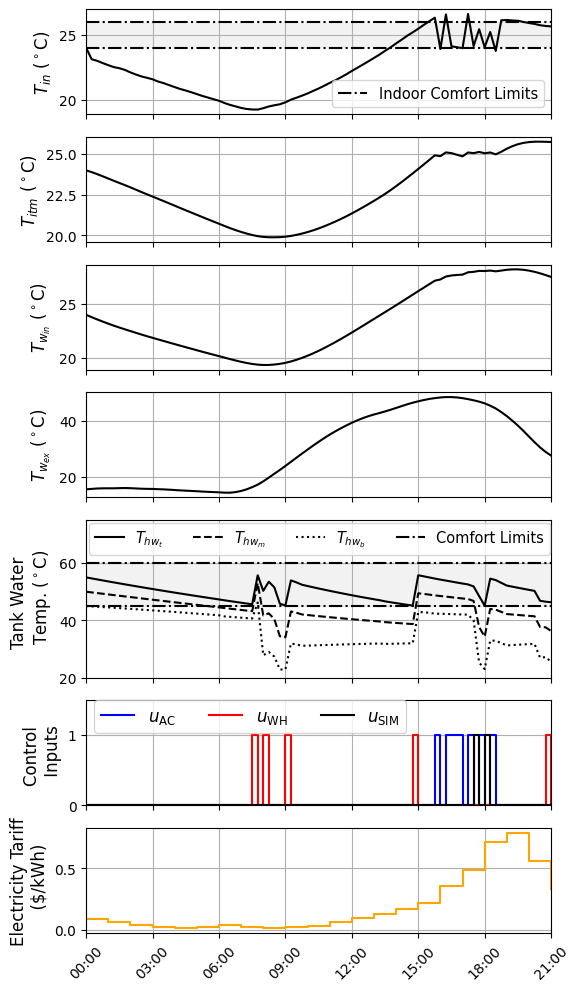

In [445]:
"""Supervisory MPC figures"""
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec
from matplotlib.ticker import StrMethodFormatter
import pandas as pd
import pytz
from matplotlib.lines import Line2D


# Plot Indoor Temperature (T_in) 

# Create the figure with subplots
fig = plt.figure(figsize=(6, 12))
gs = gridspec.GridSpec(7, 1, figure=fig, height_ratios=[2, 2, 2, 2, 3, 2, 2], hspace=0.2)

# Create subplots
axs = [plt.subplot(gs[i, 0]) for i in range(7)]

axs[0].plot(time_closed_loop, closed_loop_states[0, :-1], color="black")
axs[0].set_ylabel('$T_{in}$ ($^\circ$C)', color="black", fontsize=12)
axs[0].grid(True)
axs[0].xaxis.set_major_locator(mdates.HourLocator(interval=3))
axs[0].xaxis.set_major_formatter(mdates.DateFormatter("%H:00", tz=pytz.timezone('US/Pacific')))
axs[0].tick_params(axis='x', rotation=45)
axs[0].set_xlim(time_closed_loop[0], time_closed_loop[-1])
axs[0].tick_params(axis='x', labelbottom=False)

comfort_range_lower = comfort_range_T_in[0]
comfort_range_upper = comfort_range_T_in[1]

# Add boundaries for comfort range
axs[0].axhspan(comfort_range_T_in[0], comfort_range_T_in[1], facecolor='gray', alpha=0.1)  # Comfort range
axs[0].axhline(y=comfort_range_T_in[0], color="black", linestyle='dashdot', label='Comfort Lower Limit')  # Lower limit
axs[0].axhline(y=comfort_range_T_in[1], color="black", linestyle='dashdot', label='Comfort Upper Limit')  # Upper limit

custom_handles = [Line2D([], [], color='black', linestyle='dashdot')]
# Set the labels for the legend entries
legend_labels = ['Indoor Comfort Limits']

# Add the legend with custom handles and labels
axs[0].legend(custom_handles, legend_labels, loc='lower right', fontsize = 10.5)


axs[1].plot(time_closed_loop, closed_loop_states[1, :-1], color="black")
axs[1].set_ylabel('$T_{itm}$ ($^\circ$C)', color="black", fontsize=12)
axs[1].grid(True)
axs[1].xaxis.set_major_locator(mdates.HourLocator(interval=3))
axs[1].xaxis.set_major_formatter(mdates.DateFormatter("%H:00", tz=pytz.timezone('US/Pacific')))
axs[1].tick_params(axis='x', rotation=45)
axs[1].set_xlim(time_closed_loop[0], time_closed_loop[-1])
axs[1].tick_params(axis='x', labelbottom=False)

axs[2].plot(time_closed_loop, closed_loop_states[2, :-1], color="black")
axs[2].set_ylabel('$T_{w_{in}}$ ($^\circ$C)', color="black", fontsize=12)
axs[2].grid(True)
axs[2].xaxis.set_major_locator(mdates.HourLocator(interval=3))
axs[2].xaxis.set_major_formatter(mdates.DateFormatter("%H:00", tz=pytz.timezone('US/Pacific')))
axs[2].tick_params(axis='x', rotation=45)
axs[2].set_xlim(time_closed_loop[0], time_closed_loop[-1])
axs[2].tick_params(axis='x', labelbottom=False)


axs[3].plot(time_closed_loop, closed_loop_states[3, :-1], color="black")
axs[3].set_ylabel('$T_{w_{ex}}$ ($^\circ$C)', color="black", fontsize=12)
axs[3].grid(True)
axs[3].xaxis.set_major_locator(mdates.HourLocator(interval=3))
axs[3].xaxis.set_major_formatter(mdates.DateFormatter("%H:00", tz=pytz.timezone('US/Pacific')))
axs[3].tick_params(axis='x', rotation=45)
axs[3].set_xlim(time_closed_loop[0], time_closed_loop[-1])
axs[3].tick_params(axis='x', labelbottom=False)


# Plot Hot water draw
axs[4].plot(time_closed_loop, closed_loop_states[9, :-1], label='$T_{hw_t}$', linestyle='solid', color='black')
axs[4].plot(time_closed_loop, closed_loop_states[8, :-1], label='$T_{hw_m}$', linestyle='dashed', color='black')
axs[4].plot(time_closed_loop, closed_loop_states[7, :-1], label='$T_{hw_b}$', linestyle='dotted', color='black')

axs[4].set_ylabel('Tank Water \n Temp. ($^\circ$C)', color='black', fontsize=12)
axs[4].tick_params(axis='y', labelcolor='black')  
axs[4].grid(True)
axs[4].xaxis.set_major_locator(mdates.HourLocator(interval=3))
axs[4].xaxis.set_major_formatter(mdates.DateFormatter("%H:00", tz=pytz.timezone('US/Pacific')))
axs[4].set_xlim(time_closed_loop[0], time_closed_loop[-1])
axs[4].xaxis.grid(True)


comfort_range_lower = comfort_range_T_w[0]
comfort_range_upper = comfort_range_T_w[1]
axs[4].fill_between(time_closed_loop, comfort_range_lower, comfort_range_upper, color='gray', alpha=0.1, label='Comfort Range')

axs[4].axhline(y=comfort_range_T_w[0], color="black", linestyle='dashdot', label='Limits')  # Lower limit
axs[4].axhline(y=comfort_range_T_w[1], color="black", linestyle='dashdot', label='Limit')  # Upper limit
axs[4].set_ylim(20,75)

# Create custom legend handles for each entry in the legend
custom_handles = [
    Line2D([], [], color='black', linestyle='solid'),  # Line for $T_{hw_t}$
    Line2D([], [], color='black', linestyle='dashed'),  # Line for $T_{hw_m}$
    Line2D([], [], color='black', linestyle='dotted'),  # Line for $T_{hw_b}$
    Line2D([], [], color='black', linestyle='dashdot')  # Line for "Limits" with dashed linestyle
]

# Set the labels for the legend entries
legend_labels = ['$T_{hw_t}$', '$T_{hw_m}$', '$T_{hw_b}$', 'Comfort Limits']

# Add the legend with custom handles and labels
axs[4].legend(custom_handles, legend_labels, loc='upper left', bbox_to_anchor=(-0.01, 1.03), ncol=4, fontsize = 10.5)

axs[4].tick_params(axis='x', labelbottom=False)

# Plot Control Inputs U_AC, U_WH, U_SIM
axs[5].step(time_closed_loop, closed_loop_control_inputs[0, :], label='$u_{\mathrm{AC}}$', where='post', color='blue')
axs[5].step(time_closed_loop, closed_loop_control_inputs[1, :], label='$u_{\mathrm{WH}}$', where='post', color='red')
axs[5].step(time_closed_loop, closed_loop_control_inputs[2, :], label='$u_{\mathrm{SIM}}$', where='post', color='black')
# Plot Control Inputs U_AC, U_WH, U_SIM (continued)
axs[5].set_ylabel('Control \n Inputs', color='black', fontsize=12)
axs[5].tick_params(axis='y', labelcolor='black')  
axs[5].grid(True)
axs[5].xaxis.set_major_locator(mdates.HourLocator(interval=3))
axs[5].xaxis.set_major_formatter(mdates.DateFormatter("%H:00", tz=pytz.timezone('US/Pacific')))
axs[5].set_xlim(time_closed_loop[0], time_closed_loop[-1])
axs[5].tick_params(axis='x', labelbottom=False)
axs[5].set_ylim(0,1.49)
axs[5].set_yticks([0, 1])
# Update the legend for the combined subplot
axs[5].legend(loc='upper left',bbox_to_anchor=(0, 1.08), ncol=3, fontsize = 12)

# Plot Electricity Tariff
axs[6].step(time_closed_loop, cost_elec[:num_steps_closed_loop], label='Electricity Tariff (\$/kWh)', where='post', color='orange')
axs[6].set_ylabel('Electricity Tariff\n  (\$/kWh)', color='black', fontsize=12)
axs[6].tick_params( labelcolor='black')
axs[6].grid(True)
axs[6].xaxis.set_major_locator(mdates.HourLocator(interval=3))
axs[6].xaxis.set_major_formatter(mdates.DateFormatter("%H:00", tz=pytz.timezone('US/Pacific')))
axs[6].set_xlim(time_closed_loop[0], time_closed_loop[-1])
axs[6].tick_params(axis='x', rotation=45)

# Show the plots
plt.show()


In [460]:
# Find the maximum indoor temp
max_value = np.max(closed_loop_states[0, :-1])
print("Maximum indoor temperature (C):", max_value)


Maximum indoor temperature (C): 26.612632427705254
